In [25]:
import pickle
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [23]:
class ConditionalImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, conditional_offset=5):
        self.data_dir = data_dir
        self.transform = transform
        self.conditional_offset = conditional_offset
        self.data = []
        self._load_data()

    def _load_data(self):
        files = sorted([os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.endswith('.mpy')])
        for file in files:
            with open(file, 'rb') as f:
                images = pickle.load(f)
                if isinstance(images, list):
                    images = np.array(images)
                self.data.append(images)

    def __len__(self):
        return sum(len(images) for images in self.data) - len(self.data) * self.conditional_offset

    def __getitem__(self, idx):
        collection_idx, image_idx = self._get_indices(idx)
        target_image = self.data[collection_idx][image_idx]
        cond_image = self.data[collection_idx][image_idx - self.conditional_offset]

        if self.transform:
            target_image = self.transform(target_image)
            cond_image = self.transform(cond_image)

        return target_image, cond_image

    def _get_indices(self, idx):
        cumulative_length = 0
        for collection_idx, images in enumerate(self.data):
            collection_length = len(images) - self.conditional_offset
            if idx < cumulative_length + collection_length:
                return collection_idx, idx - cumulative_length + self.conditional_offset
            cumulative_length += collection_length
        raise IndexError(f"Index {idx} out of range")
    

DATA_PATH = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/bin_frames"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

dataset = ConditionalImageDataset(DATA_PATH, transform=transform)

# Split the dataset
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

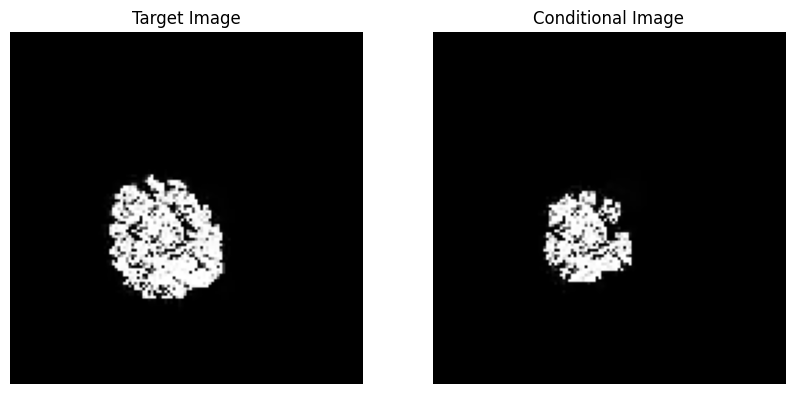

In [24]:
import random 

def plot_random_sample(dataset):
    # Get a random index
    random_idx = random.randint(0, len(dataset) - 1)
    
    # Get the image and conditional image
    image, cond_image = dataset[random_idx]
    
    # Convert to numpy arrays for plotting
    image = image.numpy().transpose(1, 2, 0)  # Transpose from (C, H, W) to (H, W, C)
    cond_image = cond_image.numpy().transpose(1, 2, 0)  # Transpose from (C, H, W) to (H, W, C)
    
    # Denormalize the images
    image = (image * 0.5 + 0.5).clip(0, 1)
    cond_image = (cond_image * 0.5 + 0.5).clip(0, 1)
    
    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("Target Image")
    axs[0].axis('off')
    
    axs[1].imshow(cond_image, cmap='gray')
    axs[1].set_title("Conditional Image")
    axs[1].axis('off')
    
    plt.show()

# Assuming dataset is already created
plot_random_sample(test_dataset)

## CONV LSTM for wildfire predictions

In [22]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))
        
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.bias = bias
        self.return_all_layers = return_all_layers
        
        cell_list = []
        
        for i in range(0, self.num_layers):
            curr_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]
            
            cell_list.append(ConvLSTMCell(input_dim=curr_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))
            
        self.cell_list = nn.ModuleList(cell_list)
        
    def forward(self, x):
        b, _, h, w = x.shape
        hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))
        
        layer_output_list = []
        last_state_list = []
        
        cur_layer_input = x.unsqueeze(1)
        
        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(1):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h,c])
                
                output_inner.append(h)
                
            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output
            
            layer_output_list.append(layer_output)
            last_state_list.append([h, c])
            
        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]
            
        return layer_output_list, last_state_list
        
    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states
    
class WildfirePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(WildfirePredictor, self).__init__()
        self.convLstm = ConvLSTM(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers, return_all_layers=False)
        self.conv = nn.Conv2d(hidden_dim[-1], 1, kernel_size=1, padding=0)
        
    def forward(self, x):
        layer_output_list, last_state_list = self.convLstm(x)
        out = layer_output_list[0][:, -1, :, :, :]
        out = self.conv(out)
        
        return out

In [27]:
# Initialize model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = WildfirePredictor(input_dim=1, hidden_dim=[64, 64, 64], kernel_size=[3, 3, 3], num_layers=3)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    for target_image, cond_image in train_loader:
        cond_image = cond_image.float().to(device)
        target_image = target_image.float().to(device)

        optimizer.zero_grad()
        output = model(cond_image)
        loss = criterion(output, target_image)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation loop
model.eval()
with torch.no_grad():
    for cond_image, target_image in test_loader:
        cond_image = cond_image.float().to(device)
        target_image = target_image.float().to(device)
        output = model(cond_image)
        loss = criterion(output, target_image)
        print(f'Test Loss: {loss.item():.4f}')

cuda
Epoch [1/10], Loss: 0.1018
Epoch [2/10], Loss: 0.0681
Epoch [3/10], Loss: 0.0559
Epoch [4/10], Loss: 0.0609
Epoch [5/10], Loss: 0.0468
Epoch [6/10], Loss: 0.0507
Epoch [7/10], Loss: 0.0556
Epoch [8/10], Loss: 0.0703
Epoch [9/10], Loss: 0.0484
Epoch [10/10], Loss: 0.0448
Test Loss: 0.0451
Test Loss: 0.0441
Test Loss: 0.0320


In [28]:
MODEL_SAVE_PATH = "C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/conv_lstm_1.pt"
# torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [30]:
load_model = WildfirePredictor(input_dim=1, hidden_dim=[64, 64, 64], kernel_size=[3, 3, 3], num_layers=3)
load_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
load_model.to(device)

WildfirePredictor(
  (convLstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [34]:
# Function to generate predictions
def generate_predictions(model, test_loader):
    model.eval()
    predictions = []
    ground_truths = []
    inputs = []

    with torch.no_grad():
        for target_images, cond_images in test_loader:
            cond_images = cond_images.float().to(device)
            target_images = target_images.float().to(device)
            output = model(cond_images)
            predictions.append(output.cpu())
            ground_truths.append(target_images.cpu())
            inputs.append(cond_images.cpu())

    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)
    inputs = torch.cat(inputs, dim=0)

    return predictions, ground_truths, inputs

preds, ground_truths, inputs = generate_predictions(load_model, test_loader)

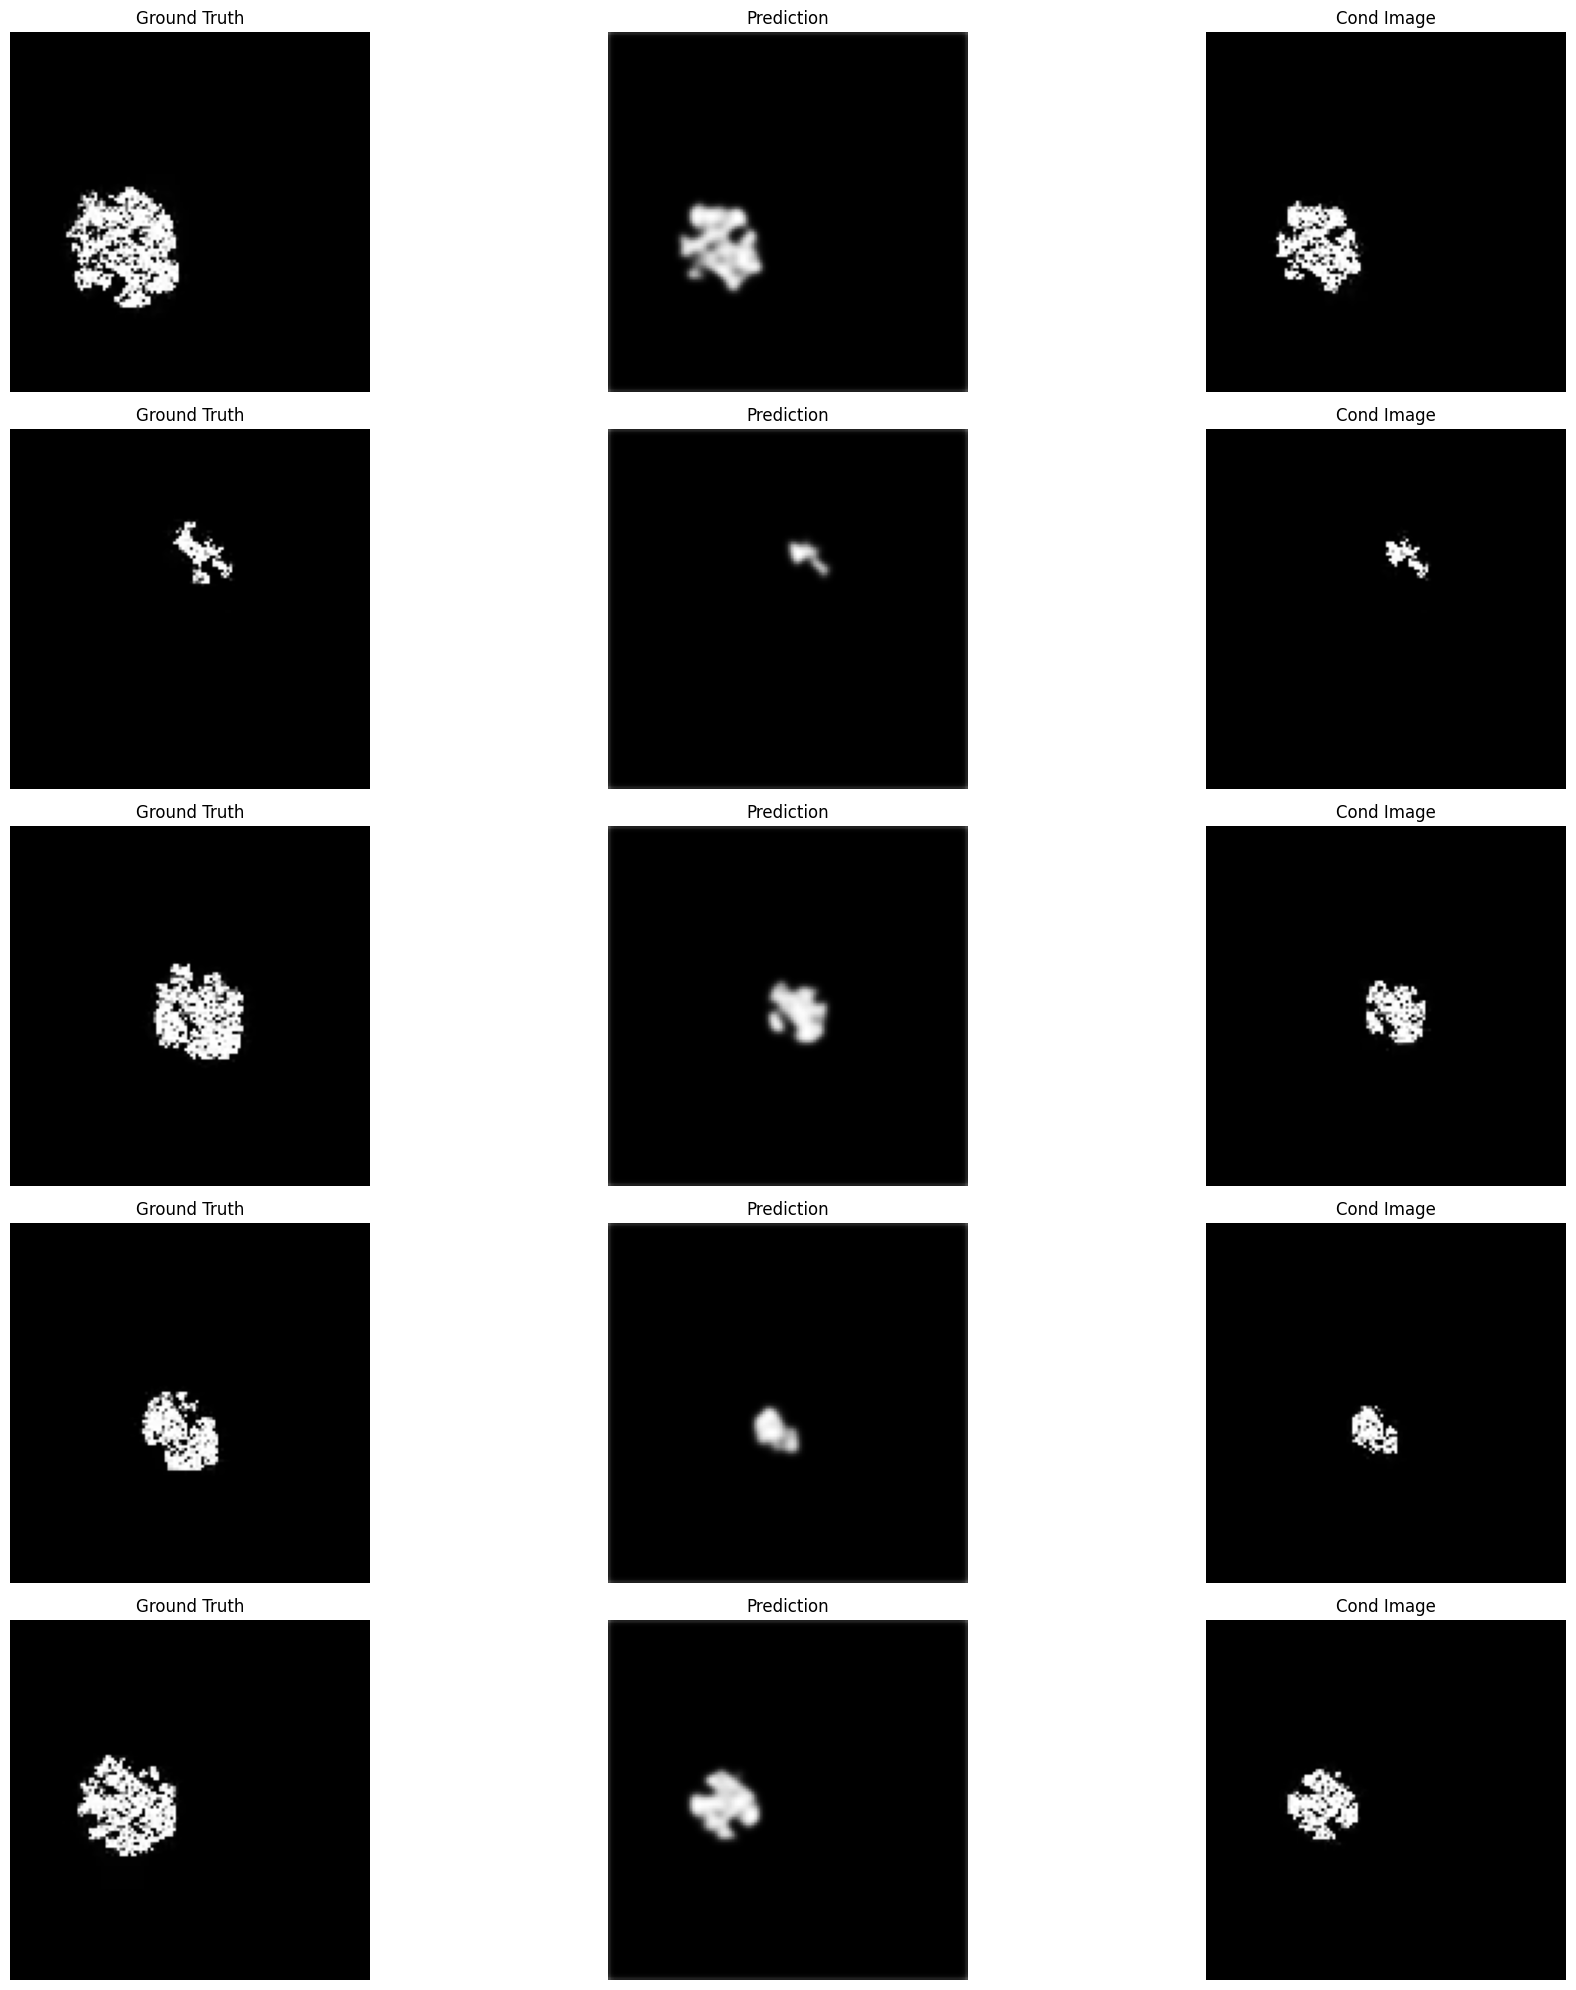

In [36]:
# Function to plot predictions and ground truth images
def plot_predictions(predictions, ground_truths, input_images, num_images=5):
    fig, axs = plt.subplots(num_images, 3, figsize=(20, 20))
    for i in range(num_images):
        pred_img = predictions[i].squeeze(0)
        true_img = ground_truths[i].squeeze(0)
        in_img = input_images[i].squeeze(0)

        axs[i, 0].imshow(true_img, cmap='gray')
        axs[i, 0].set_title('Ground Truth')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(pred_img, cmap='gray')
        axs[i, 1].set_title('Prediction')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(in_img, cmap='gray')
        axs[i, 2].set_title('Cond Image')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_predictions(preds, ground_truths, inputs)